## Habitat Suitability

#### Overview

#### Data Description


#### Data Citation


#### Methods


#### Analysis

Import Libraries

In [74]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pathlib
import zipfile
from glob import glob
from math import floor, ceil

import pandas as pd
import geopandas as gpd
import rioxarray as rxr

import matplotlib.pyplot as plt
# interactive plots of vector data
import hvplot.pandas

Load Data

In [22]:
# Define downloads directory
downloads_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Downloads'
)

# Create project data directory 
data_dir = os.path.join(
    # Home directory
    pathlib.Path.home(),
    'Projects',
    # Project directory
    'habitat-suitability',
    'data'
)

# Define the directory name for USFS data
grassland_units_dir = os.path.join(data_dir, 'usfs-national-grasslands')

os.makedirs(downloads_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

In [23]:
# Only extract once
usfs_pattern = os.path.join(grassland_units_dir, '*.shp')

if not glob(usfs_pattern):
    usfs_zip = f'{downloads_dir}/S_USA.NationalGrassland.zip'

    # Unzip data
    with zipfile.ZipFile(usfs_zip, 'r') as zip:
        zip.extractall(path=grassland_units_dir)

# Find the extracted .shp file path
usfs_path = glob(usfs_pattern)[0]

# Load USFS grasslands units from shapefile
usfs_grasslands_gdf = (
    gpd.read_file(usfs_path)
)

usfs_grasslands_gdf.head()

,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
0,281771010328,Fort Pierre National Grassland,209044.225,0.095149,1.455518,"POLYGON ((-100.08409 44.28162, -100.08409 44.2..."
1,295507010328,Butte Valley National Grassland,19489.170,0.008557,0.853736,"MULTIPOLYGON (((-121.996 41.84049, -121.996 41..."
2,295508010328,Kiowa National Grassland,144281.321,0.058543,9.858642,"MULTIPOLYGON (((-104.30414 36.08063, -104.3041..."
3,295509010328,Sheyenne National Grassland,70428.175,0.033356,4.097398,"MULTIPOLYGON (((-97.31081 46.51457, -97.30559 ..."
4,295510010328,Cedar River National Grassland,6717.517,0.003157,0.999947,"MULTIPOLYGON (((-101.82221 45.95896, -101.8170..."


Explore Sites

In [20]:
# California: Butte Valley National Grassland
ca_grassland_gdf = usfs_grasslands_gdf.loc[usfs_grasslands_gdf['GRASSLANDN'] == 'Butte Valley National Grassland']

# plot with EsriImagery basemap  
ca_grassland_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Butte Valley National Grassland',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [21]:
# Oregon: Crooked River National Grassland
or_grassland_gdf = usfs_grasslands_gdf.loc[usfs_grasslands_gdf['GRASSLANDN'] == 'Crooked River National Grassland']

# plot with EsriImagery basemap  
or_grassland_gdf.hvplot(
    geo=True, tiles='EsriImagery',
    title='Crooked River National Grassland',
    fill_color=None, line_color='lightblue', line_width=3,
    frame_width=600, frame_height=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [65]:
def create_polaris_url(soil_prop, stat, soil_depth, gdf_bounds):
    """Create POLARIS dataset url using site bounds"""

    # Get latitude and longitude bounds from site
    min_lon, min_lat, max_lon, max_lat = gdf_bounds

    site_min_lon = ceil(min_lon)
    site_min_lat = floor(min_lat)
    site_max_lon = ceil(max_lon)
    site_max_lat = ceil(max_lat)

    soil_template = (
        "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
        "{soil_prop}/"
        "{stat}/"
        "{soil_depth}/"
        "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
    )

    soil_url = soil_template.format(
        soil_prop=soil_prop, stat=stat, soil_depth=soil_depth,
        min_lat=site_min_lat, max_lat=site_max_lat, 
        min_lon=site_min_lon, max_lon=site_max_lon
    )

    return soil_url

In [70]:
# Set site parameters
soil_prop = 'ph'
soil_prop_stat = 'mean'
soil_depth = '30_60' # cm 

# CA site
ca_polaris_url = create_polaris_url(soil_prop, soil_prop_stat, soil_depth, ca_grassland_gdf.total_bounds)
print('CA site: ', ca_polaris_url)

# OR site
or_polaris_url = create_polaris_url(soil_prop, soil_prop_stat, soil_depth, or_grassland_gdf.total_bounds)
print('OR site: ', or_polaris_url)

CA site:  http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4142_lon-122-121.tif
OR site:  http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4445_lon-121-120.tif


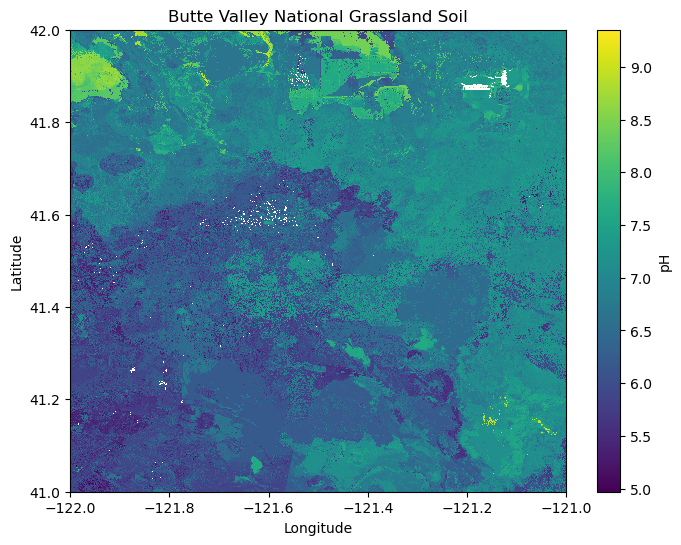

In [84]:
ca_soil_da = rxr.open_rasterio(
    ca_polaris_url,
    mask_and_scale=True # for the fill value
).squeeze()

fig = plt.figure(figsize=(8, 6)) 
ax = plt.axes()

# mean pH values (~5-10 pH)
ca_soil_plt = ca_soil_da.plot(cbar_kwargs={'label': 'pH'})

plt.title('Butte Valley National Grassland Soil')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

fig.savefig("images/Butte-Valley-National-Grassland-Soil.png") 

ca_soil_plt

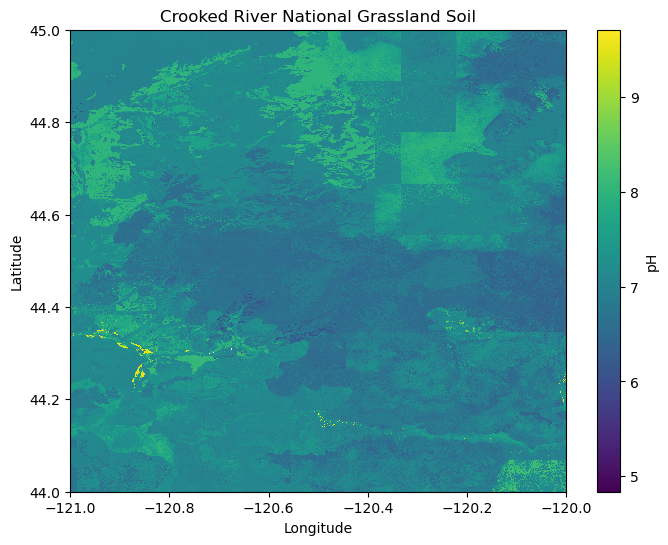

In [85]:
or_soil_da = rxr.open_rasterio(
    or_polaris_url,
    mask_and_scale=True # for the fill value
).squeeze()

fig = plt.figure(figsize=(8, 6)) 
ax = plt.axes()

# mean pH values (~5-9 pH)
or_soil_plt = or_soil_da.plot(cbar_kwargs={'label': 'pH'})

plt.title('Crooked River National Grassland Soil')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

fig.savefig("images/Crooked-River-National-Grassland-Soil.png") 

or_soil_plt

#### Discussion


#### References

